In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [4]:
import dizx
from dizx import Edge
from dizx import clifford_simplifier as simp
Phase = dizx.CliffordPhase
d = 3
Z = dizx.VertexType.Z
X = dizx.VertexType.X

In [53]:
from sympy import symbols
a = symbols("a")
ainv = symbols("ainv")
b = symbols("b")
binv = symbols("binv")
Hadj = dizx.gates.HAD(0,adjoint=True)
H = dizx.gates.HAD(0)
S = dizx.gates.S(0)

lhs = dizx.Circuit(qudit_amount=1, dim=3)
lhs += H**-1 + S**-a + H**-1 + S**-ainv + H**-1 + S**(-a*(b+1)) + H


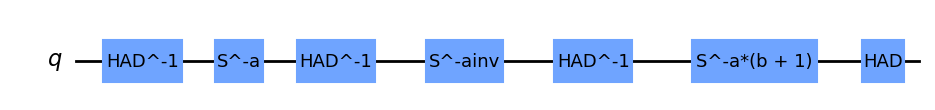

In [54]:
lhs.draw()

In [55]:
m = lhs.to_symplectic_matrix()
m

Matrix([
[a*ainv*(b + 1) - 1, a*(b + 1)*(a*ainv - 1) - a],
[              ainv,                 a*ainv - 1]])

In [56]:
dizx.symplectic.reduce_matrix(m,[(a,ainv),(b,binv)])

Matrix([
[   b, -a],
[ainv,  0]])

In [114]:
#R28 from supplement, but with each S replaced by S**2 to match our semantics. Also had to add another CZ at start to fix semantics.
from dizx.circuit.gates import CZ, CX, HAD, S, Z, X

lhs = dizx.Circuit(qudit_amount=2, dim=3)
lhs += CZ(0,1)
lhs += HAD(0)**2 + HAD(1)
lhs += CZ(0,1)
lhs += CX(1,0)
rhs = dizx.Circuit(qudit_amount=2, dim=3)
rhs += HAD(1)
rhs += CZ(0,1) + CX(1,0)
rhs += S(1)**2 + HAD(1)**2 + S(1)**2
rhs += CX(0,1)**2
rhs += S(1)**2 + Z(1)


In [15]:
dizx.symplectic.compare_matrices(lhs.to_symplectic_matrix(), rhs.to_symplectic_matrix(), modulus=3)

True

In [163]:
#R27 from supplement, but with each S replaced by S**2 to match our semantics.
from dizx.circuit.gates import SWAP

lhs = dizx.Circuit(qudit_amount=2, dim=3)
lhs += CZ(0,1)
lhs += HAD(0)
lhs += SWAP(0,1)
lhs += CZ(0,1)
lhs += CX(1,0)
rhs = dizx.Circuit(qudit_amount=2, dim=3)
rhs += S(1)**2 + HAD(0)
rhs += S(0) + HAD(1)
rhs += CZ(0,1)**2
rhs += HAD(1) + S(1)**2

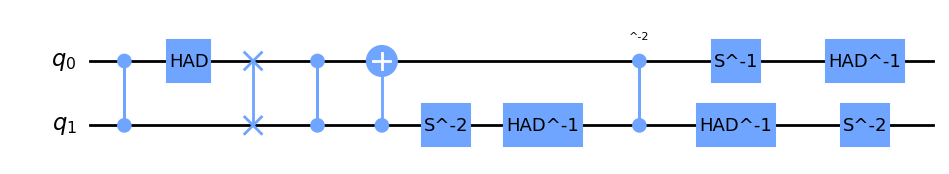

Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]])

In [260]:
c = lhs + rhs.adjoint()
display(c.draw())
dizx.symplectic.modulo_matrix(c.to_symplectic_matrix(),3)

In [261]:
cs = simp.CliffordSimplifier(c)
cs.check_semantics_each_step = True

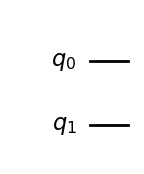

Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]])

In [268]:
cs.simple_optimize()

display(cs.circuit.draw())
dizx.symplectic.modulo_matrix(cs.circuit.to_symplectic_matrix(),3)

In [147]:
cs.push_S_past_CX()

True

In [149]:
cs.push_CZ_past_CX()

True

In [267]:
cs.push_H_gate()

True

In [265]:
cs.transform_CX_to_SWAP()

True

In [158]:
cs.toggle_pair_of_CX_gates()

True

In [ ]:
cs.display_widget()

Remove identity
None
        CZ(0,1)
                HAD(0)
                        CX(0,1)
                                CX^2(1,0)
                                        HAD^3(1)
                                                SWAP(0,1)
                                                        HAD^6(1)
                                                        X^4(0)



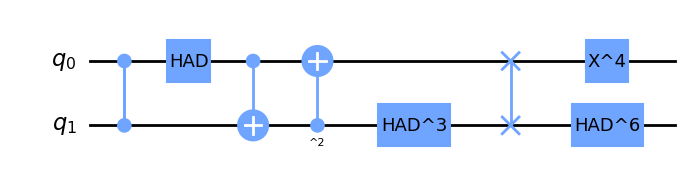

In [234]:
index = -2
print(cs.steps_done[index])
print(cs.dags[index])
cs.circuit_list[index].draw()

In [235]:
print(cs.circuit_list[index].to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
quditdim 3
qreg q[2];
cz q[0], q[1];
h q[0];
cx q[0], q[1];
cx^2 q[1], q[0];
h^3 q[1];
swap q[0], q[1];
h^6 q[1];
x^4 q[0];



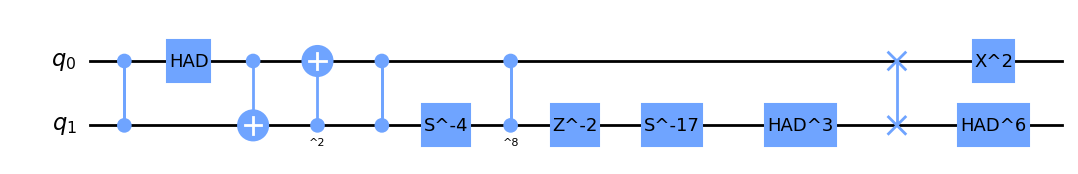

In [169]:
cs.circuit.draw()

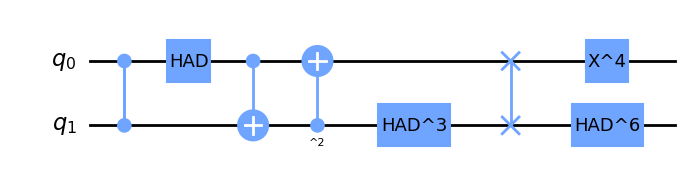

None
        CZ(0,1)
                HAD(0)
                        CX(0,1)
                                CX^2(1,0)
                                        HAD^3(1)
                                                SWAP(0,1)
                                                        HAD^6(1)
                                                        X^4(0)

None
        CZ(0,1)
                HAD(0)
                        CX^-2(1,0)
                                SWAP(0,1)
                                        HAD^3(1)
                                                SWAP(0,1)
                                                        HAD^6(1)
                                                        X^4(0)
                                        HAD^2(0)
                                                SWAP(0,1)
                                                        HAD^6(1)
                                                        X^4(0)



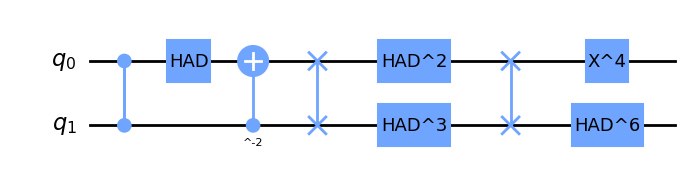

In [236]:
# TODO: This rewrite breaks DAG structure
c = dizx.Circuit.from_qasm_file(r'..\tests\circuits\transform_CX_to_SWAP.qasm')
display(c.draw())
cs2 = simp.CliffordSimplifier(c)
print(cs2.dag)
cs2.transform_CX_to_SWAP()
print(cs2.dag)
cs2.circuit.draw()

In [237]:
m1 = cs2.circuit_list[0].to_symplectic_matrix()
m2 = cs2.circuit.to_symplectic_matrix()
display(m1)
display(m2)
dizx.symplectic.compare_matrices(m1,m2,modulus=3)

Matrix([
[-1,  0,  0,  3],
[ 0, -1,  0,  0],
[ 0,  3, -1,  0],
[ 0,  0,  0, -1]])

Matrix([
[ 1, 0,  0, 0],
[ 0, 1, -3, 0],
[ 0, 0,  1, 0],
[-3, 0,  0, 1]])

False

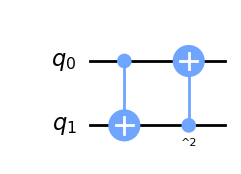

In [247]:
qasm = r"""
OPENQASM 2.0;
include "qelib1.inc";
quditdim 3
qreg q[2];
cx q[0], q[1];
cx^2 q[1], q[0];
"""
c = dizx.Circuit.from_qasm(qasm)
c.draw()

In [246]:
dizx.symplectic.CX(0,1,2,1)

Matrix([
[1, 0, 0,  0],
[0, 1, 0, -1],
[1, 0, 1,  0],
[0, 0, 0,  1]])

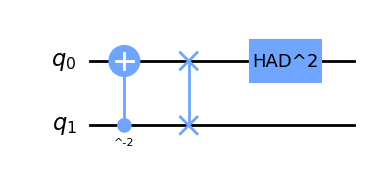

In [248]:
cs = simp.CliffordSimplifier(c)
cs.transform_CX_to_SWAP()
cs.circuit.draw()

In [249]:
m1 = cs.circuit_list[0].to_symplectic_matrix()
m2 = cs.circuit.to_symplectic_matrix()
m1 = dizx.symplectic.modulo_matrix(m1,3)
m2 = dizx.symplectic.modulo_matrix(m2,3)
display(m1)
display(m2)
dizx.symplectic.compare_matrices(m1,m2,modulus=3)

Matrix([
[0, 0, 2, 0],
[0, 1, 0, 2],
[1, 0, 1, 0],
[0, 1, 0, 0]])

Matrix([
[0, 0, 2, 0],
[0, 1, 0, 2],
[1, 0, 1, 0],
[0, 1, 0, 0]])

True

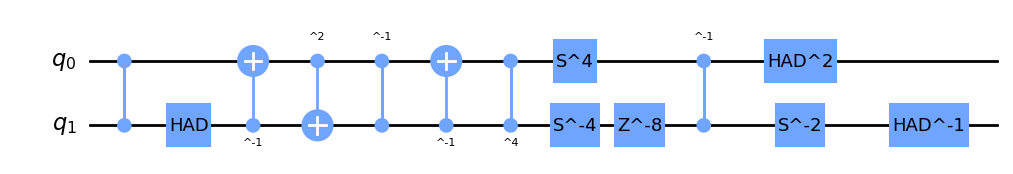

In [3]:
c2 = dizx.Circuit.from_qasm_file('../circuits/pauli_push1.qasm')
c2.draw()

In [4]:
cs = simp.CliffordSimplifier(c2)
# cs.simple_optimize()
# cs.push_CZ_past_CX()
# cs.simple_optimize()
# cs.transform_CX_to_SWAP()
# cs.simple_optimize()
# cs.transform_CX_to_SWAP()
# cs.circuit.draw()

In [5]:
cs.push_pauli()

True

In [6]:
print(cs.dags[-1])

None
        CZ(0,1)
                HAD(1)
                        CX^-1(1,0)
                                CX^2(0,1)
                                        CZ^-1(0,1)
                                                CX^-1(1,0)
                                                        CZ^4(1,0)
                                                                S^4(0)
                                                                        CZ^-1(0,1)
                                                                                HAD^2(0)
                                                                                Z^-8(1)
                                                                                        S^-2(1)
                                                                                                HAD^-1(1)
                                                                S^-4(1)
                                                                        CZ^-1(0,1)
               

In [ ]:
cs.circuit.to_symplectic_matrix()

In [ ]:
c.to_symplectic_matrix()

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
cs.push_S_past_CX()

In [ ]:
print(cs.dag)

In [ ]:
"hoi"

In [ ]:
cs.display_widget()

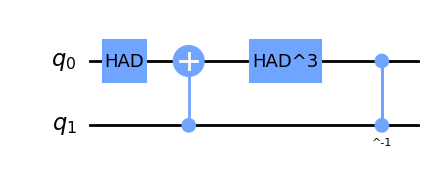

In [131]:
c = dizx.Circuit(2,3)
c += HAD(0)
c += CX(1,0)
c += HAD(0)**3
c += CZ(1,0)**-1
c.to_qiskit_rep().draw("mpl")

In [132]:
c.to_symplectic_matrix()

Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]])

In [ ]:
cs2 = simp.CliffordSimplifier(c)
cs2.push_S_gate()

In [ ]:
print(cs2.dag)
cs2.circuit.to_qiskit_rep().draw("mpl")

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
StepperWidget(cs).show()

In [ ]:
cs.push_CZ_past_CX()

In [ ]:
for circ in cs.circuit_list:
    print(circ)

In [ ]:
cs.euler_decomp()

In [ ]:
cs.euler_decomp2()

In [ ]:
cs.dag